In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('LoanStats_07_11_Clean.csv')

# Basic cleaning for plots
ls = df.copy()
grade_order = ['A','B','C','D','E','F','G']

# 1. Executive Summary

## Background of the Study
Peer-to-peer (P2P) lending platforms like Lending Club have revolutionized the credit market by connecting borrowers directly with investors. For investors, the primary challenge is risk assessment in which lenders aim to accurately determine which borrowers will repay their loans by end of term. 

The importance of this analysis lies in capital preservation and profit maximization. Unlike traditional banks, individual investors often lack sophisticated tools to screen borrowers. The work covered in this report informs one can develop and test a statistical model predicting the probability of loan default using only information available before the loan is funded. By identifying high-risk loans early, investors can avoid losses and improve their portfolio's stability.portfolio's stability.

## Summary of the Data
The dataset consists of lending data from 2007 to 2011, containing approximately 39,000 loans. 
*   **Input Variables:** We restricted our analysis to "pre-loan" variables—data available at the time of application (e.g., Income, Debt-to-Income Ratio, Loan Purpose, Employment Length).
*   **Outcome Variable:** The loan status, categorized as either "Fully Paid" (Good) or "Charged Off" (Bad).

The original data remains unomodified, but a copied data frame removes all post-loan variables. The ensures we are not using outcome variables to finetune a model. This reduces bias in testing.

### Visualizing the Landscape
As shown in **Figure 1** below, the majority of loans are graded 'B' or 'A', and the vast majority (approx. 86%) are fully paid. This **class imbalance** presents a significant challenge for statistical modeling, as a naive model could simply predict "Paid" for everyone and be 86% accurate while losing money on every default. To challenge this, we employed a "Balanced" weighting strategy. This method penalizes the model more heavily for missing a default than for misclassifying a good loan, effectively forcing the algorithm to pay attention to the minority class of bad loans.

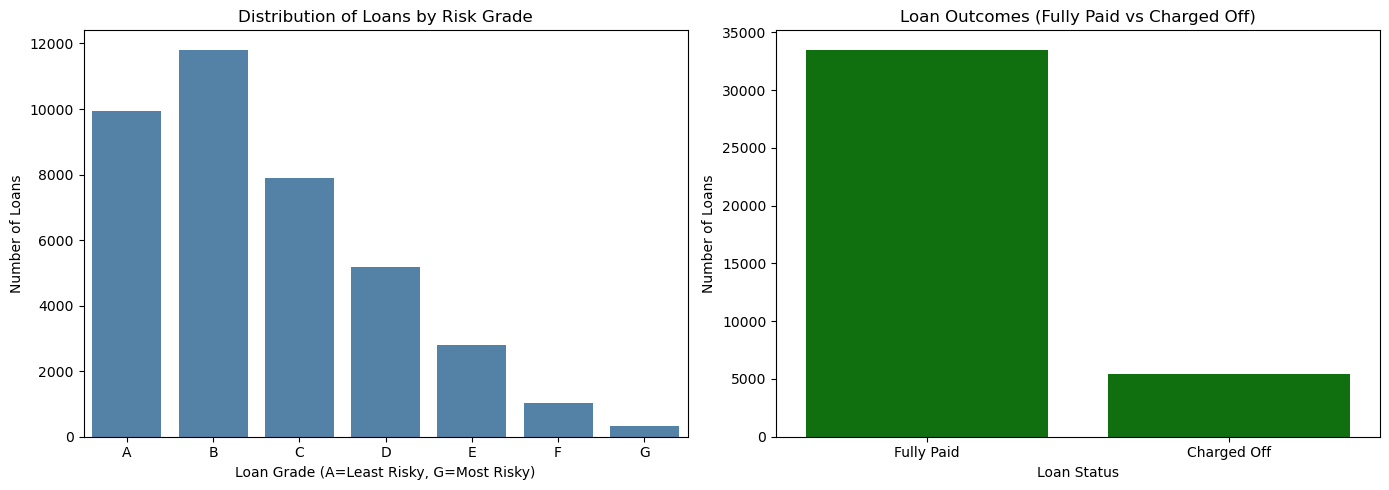

In [3]:
# Figure 1: Distribution of Loan Grades and Status
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data=ls, x='grade', order=grade_order, color='steelblue', ax=axes[0])
axes[0].set_title('Distribution of Loans by Risk Grade')
axes[0].set_xlabel('Loan Grade (A=Least Risky, G=Most Risky)')
axes[0].set_ylabel('Number of Loans')

sns.countplot(data=ls, x='loan_status', color='green', ax=axes[1])
axes[1].set_title('Loan Outcomes (Fully Paid vs Charged Off)')
axes[1].set_xlabel('Loan Status')
axes[1].set_ylabel('Number of Loans')

plt.tight_layout()
plt.show()

## Methods and Main Findings
We employed **Logistic Regression** to estimate the probability of default. 
1.  **Feature Selection:** We used a technique called **Lasso (L1 Regularization)** to sift through 82 potential variables. This method automatically discarded irrelevant features, narrowing our focus to just **13 key drivers** of risk.
2.  **Risk Factors:** The analysis confirmed that **Interest Rate**, **Annual Income**, and **Loan Term** are the strongest predictors of default.
    *   Higher interest rates and longer terms (60 months) strongly correlate with default.
    *   Higher annual income significantly reduces default risk.
3.  **Risk vs. Grade:** As seen in **Figure 2**, lower-quality grades (D, E, F, G) are associated with higher Debt-to-Income (DTI) ratios and higher revolving credit balances, validating Lending Club's grading system.

## Issues, Concerns, and Limitations
*   **The "Conservative" Trap:** Our final model is highly effective at avoiding defaults (recovering 95% of principal vs. the market average of 91%). However, by strictly avoiding risk, it also avoids the high interest rates associated with risky loans. Consequently, the **total profit** of the model-selected portfolio is lower than a "baseline" strategy of investing in everything.
*   **Historical Bias:** The data covers the 2008 financial crisis era. Borrower behavior during this period may not perfectly reflect current economic conditions.
*   **Class Imbalance:** Because defaults are rare (14%), standard models struggle to identify them without specific "re-balancing" adjustments, which we applied.

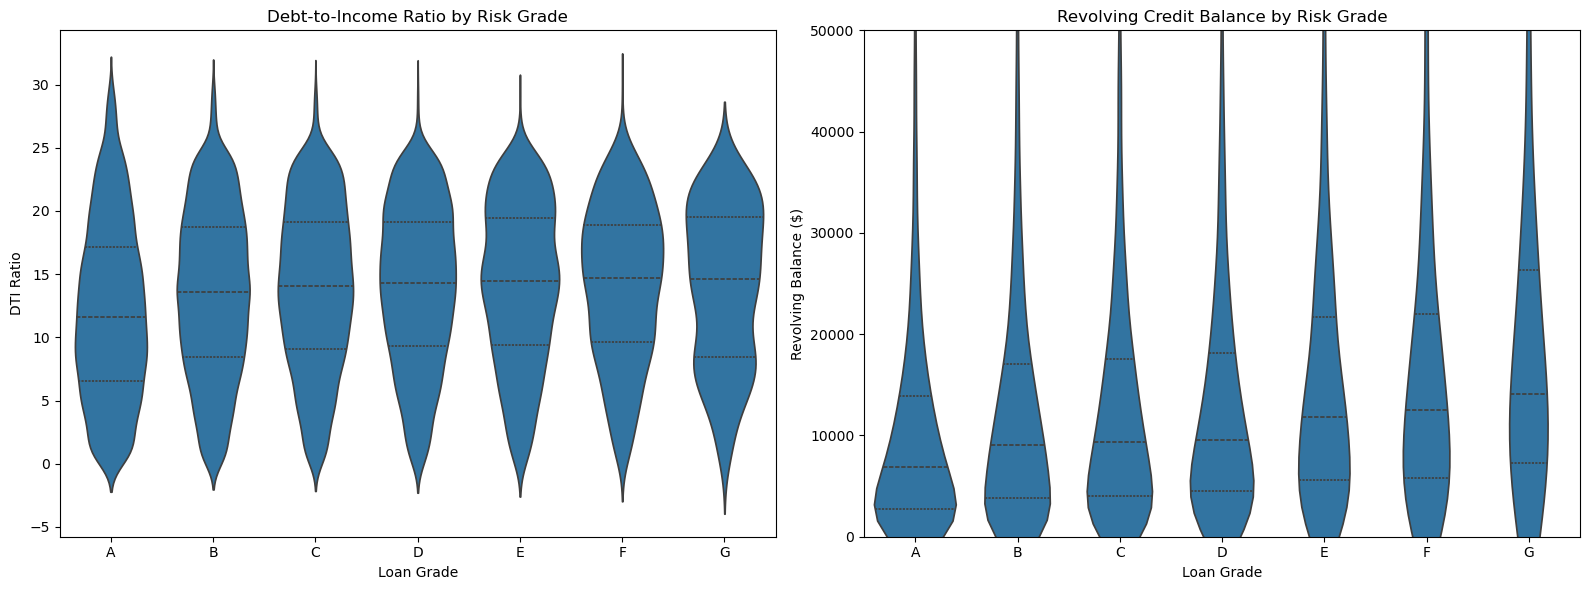

In [4]:
# Figure 2: Debt-to-Income and Revolving Balance by Grade
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.violinplot(data=ls, x='grade', y='dti', order=grade_order, inner='quartile', ax=axes[0])
axes[0].set_title('Debt-to-Income Ratio by Risk Grade')
axes[0].set_xlabel('Loan Grade')
axes[0].set_ylabel('DTI Ratio')

sns.violinplot(data=ls, x='grade', y='revol_bal', order=grade_order, inner='quartile', ax=axes[1])
axes[1].set_title('Revolving Credit Balance by Risk Grade')
axes[1].set_xlabel('Loan Grade')
axes[1].set_ylabel('Revolving Balance ($)')
axes[1].set_ylim(0, 50000) # Limiting y-axis for readability

plt.tight_layout()
plt.show()

# 2. Detailed Process of the Analysis

## 2.1 Data Summary / EDA

The data originates from Lending Club's public loan files (2007-2011). It contains a mix of:
*   **Borrower Data** Employment length, home ownership, state of residence.
*   **Financial Data of the Borrower:** Annual income, DTI, public records (bankruptcies).
*   **Loan Characteristics:** Amount, term, interest rate, grade.

**Data Cleaning & Problems:**
1.  A critical step was removing "post-loan" variables. Variables like "total payment received" or "recoveries" are outcomes, not predictors. Including them would cause the model to cheat, introducing massive bias if we wanted to expand our prediction set. 20 "pre-loan" variables were isolated. 
2.  **Feature Expansion:** Categorical variables like purpose (eg. "rent", "wedding") and sub grades were converted into numerical format using dummy encoding, expanding our dataset from 20 to 82 features. 
3.  **Imbalance:** The dataset is imbalanced (86:14). We addressed this by using class weights , which penalize the model more heavily for missing a default than for misclassifying a good loan.

## 2.2 Analyses
We compared two primary modeling approaches:

### Model 1: Lasso Logistic Regression (Feature Selection)
We initially used Lasso (L1 penalty) to identify the most important signals.

1. Lasso successfully reduced the noise, zeroing out 69 variables and keeping only 13.

2. Due to the class imbalance, the Lasso model was too "optimistic." It predicted "Fully Paid" for almost everyone to maximize simple accuracy (86%), but it failed to catch defaults.

### Model 2: Balanced Logistic Regression (Final Model)
To fix the recall issue, we removed the Lasso penalty and applied "class_weight='balanced".
1. **Result:** This model sacrificed overall accuracy (dropping to ~64%) but gained the ability to detect bad loans. If we introduced a bunch of data that had a higher proportion of bad loans, the balanced logistic regression model would be able to predict with greater accuracy and nuance than the first model.

2. **Performance:** It achieved a recall of 64% for the 'Charged Off' loans, meaning it correctly identified nearly two-thirds of the defaults. This tightens the requirement for what a "good loan" may look like. Potential losses per loan are massively shrunken. 

3. **Trade-off:** The model is "trigger happy." It flags many good loans as risky (False Positives), which reduces the total volume of loans approved, which in turn heavily reduces profit potential. 

### Portfolio Performance Comparison

| Metric | Balanced Model (Selected) | Baseline (All Loans) |
| :--- | :--- | :--- |
| **Selection Rate** | 60.67% (7,094 Loans) | 100% (11,692 Loans) |
| **Total Net Gain** | **$7,952,672** | **$15,422,783** |
| **Avg. Net Gain per Loan** | $1,121 | $1,319 |
| **Principal Recovery** | **95.19%** | 91.07% |
| **Interest Yield** | 14.19% | 18.74% |
| **Investor ROI** | 9.59% | 10.38% |

Notes: The Balanced Model is safer (higher principal recovery) but less profitable overall because it avoids high-risk, high-yield loans.

## 2.3 Conclusion

The analysis demonstrates that default risk can be predicted using pre-loan financial indicators. The **balanced logistic regression model serves as a robust filter for risk.**

**Caveats and what could be improved:**

While the model is excellent at protecting the principal investment, it is suboptimal for rofit maximization in this specific dataset. The high interest rates charged to risky borrowers often compensate for the losses from defaults. By filtering out these risky borrowers, the model reduces the portfolio's overall yield.

**Final Recommendations:**

1.  **For Conservative Investors:** The balanced logistic model is a conservative strategy. By aggressively filtering out potential defaults, it also filters out some high-risk, high-reward loans (which often have high interest rates). This makes the portfolio safer (you lose less principal) but slightly less profitable on average than a the original approach, likely because the high interest rates on risky loans compensate for the defaults in this specific dataset. The balanced logistic model assessed many "charged off loans" as risky roughly 1 in 4. Being ultra aggressive mimized aggregated losses, but always reduced potential profit. 

2.  **For Aggressive Investors:** A diversified "Baseline" strategy (investing in all available loans) yields higher total dollars, provided one has the capital to absorb the volatility of higher default rates. A more advanced model that more aggressively penalizes missclassifying good loans as bad may be more suitable. 




# 3. Appendix
See attached Jupyter Notebook `HW_4_part2.ipynb` for full code
